## This is a project to calculate the Surface Land Temperature (LST), produce the LST map, and perform the Hopspot Analysis on LST in Python and QGIS.
- To be more specific, the project creates a function to calculate LST in Python for a region where the city (Birmingham, UK in this case) is located using the Landsat-8 data (band 4, 5, and 10) and saves the result as a Geotiff file. 
- It then imports the file to QGIS to be reprojected to EPSG:27700 (British National Grid) and clipped by Birmingham boundary to produce the LST map for the city.
- After that, it converts the raster pixels of the file within the city boundary to points (shapefile) in QGIS, intersects the
points by ward boundaries within the city and saves the intersected points as a csv file before joining with the ward boundary data.
- The processed dataset ('Birmingham_LST_result_by_ward.shp') is then imported to Python for the Hotspot Analysis.

### Data sources and Python and QGIS versions:

- USGS's Landsat-8 data LC09_L1TP_203023_20220716_20230407_02_T1 (Band 4, 5 and 10) data: available at https://earthexplorer.usgs.gov/)
- Birmingham city and ward boundary data: available at https://borders.ukdataservice.ac.uk/
- Python version: 3.11.6
- QGIS version: 3.32.1

### 1. Calculating LST and saving the result as a Geotiff tile 

In [61]:
# Import libraries
import rasterio
import numpy as np
import math

# Create the function to calculate LST
def calculate_lst(band4, band5, band10):
    # Convert DN values to TOA radiance
    toa = 0.0003342 * band10 + 0.1
    
    # Calculate brightness temperature (TB) in celsius
    tb = (1329.2405 / np.log(799.0284 / toa + 1)) - 273.15
    
    # Calculate NDVI with handling zero division
    ndvi = np.where((band5 + band4) == 0, 0, (band5 - band4) / (band5 + band4))
    
    # Define NDVI min and max
    ndvi_min = np.min(ndvi)
    ndvi_max = np.max(ndvi)
    
    # Calculate PV (Vegetation Fraction)
    pv = ((ndvi - ndvi_min) / (ndvi_max - ndvi_min)) ** 2
    
    # Calculate Land Surface Emissivity (LSE)
    lse = 0.004 * pv + 0.986
    
    # Calculate LST
    lst = tb / (1 + (10.8 * tb / 14388) * np.log(lse))
    
    return lst

# Paths to the Landsat-8 Geotiff files (band 4, 5, and 10)
band4_path = r'dataset\LC09_L1TP_203023_20220716_20230407_02_T1_B4.tif'
band5_path = r'dataset\LC09_L1TP_203023_20220716_20230407_02_T1_B5.tif'
band10_path = r'dataset\LC09_L1TP_203023_20220716_20230407_02_T1_B10.tif'

# Open the raster files using rasterio
with rasterio.open(band4_path) as src4, rasterio.open(band5_path) as src5, rasterio.open(band10_path) as src10:
    # Read the raster bands as numpy arrays
    band4 = src4.read(1)
    band5 = src5.read(1)
    band10 = src10.read(1)

# Call the function to calculate LST
result_lst = calculate_lst(band4, band5, band10)

# Path to save the LST result
output_path = r'LST_Result\LST_Result.tif'

# Create a new Geotiff file for writing
with rasterio.open(
    output_path,
    'w',
    driver='GTiff',
    height=result_lst.shape[0],
    width=result_lst.shape[1],
    count=1,  # Number of bands
    dtype=result_lst.dtype,
    crs=src4.crs,
    transform=src4.transform,
) as dst:
    # Write the LST data to the Geotiff file
    dst.write(result_lst, 1)

print(f"LST result saved at: {output_path}")

LST result saved at: LST_Result\LST_Result.tif


### 2. Importing the Geotiff file to QGIS to produce the LST map (shown as follows)
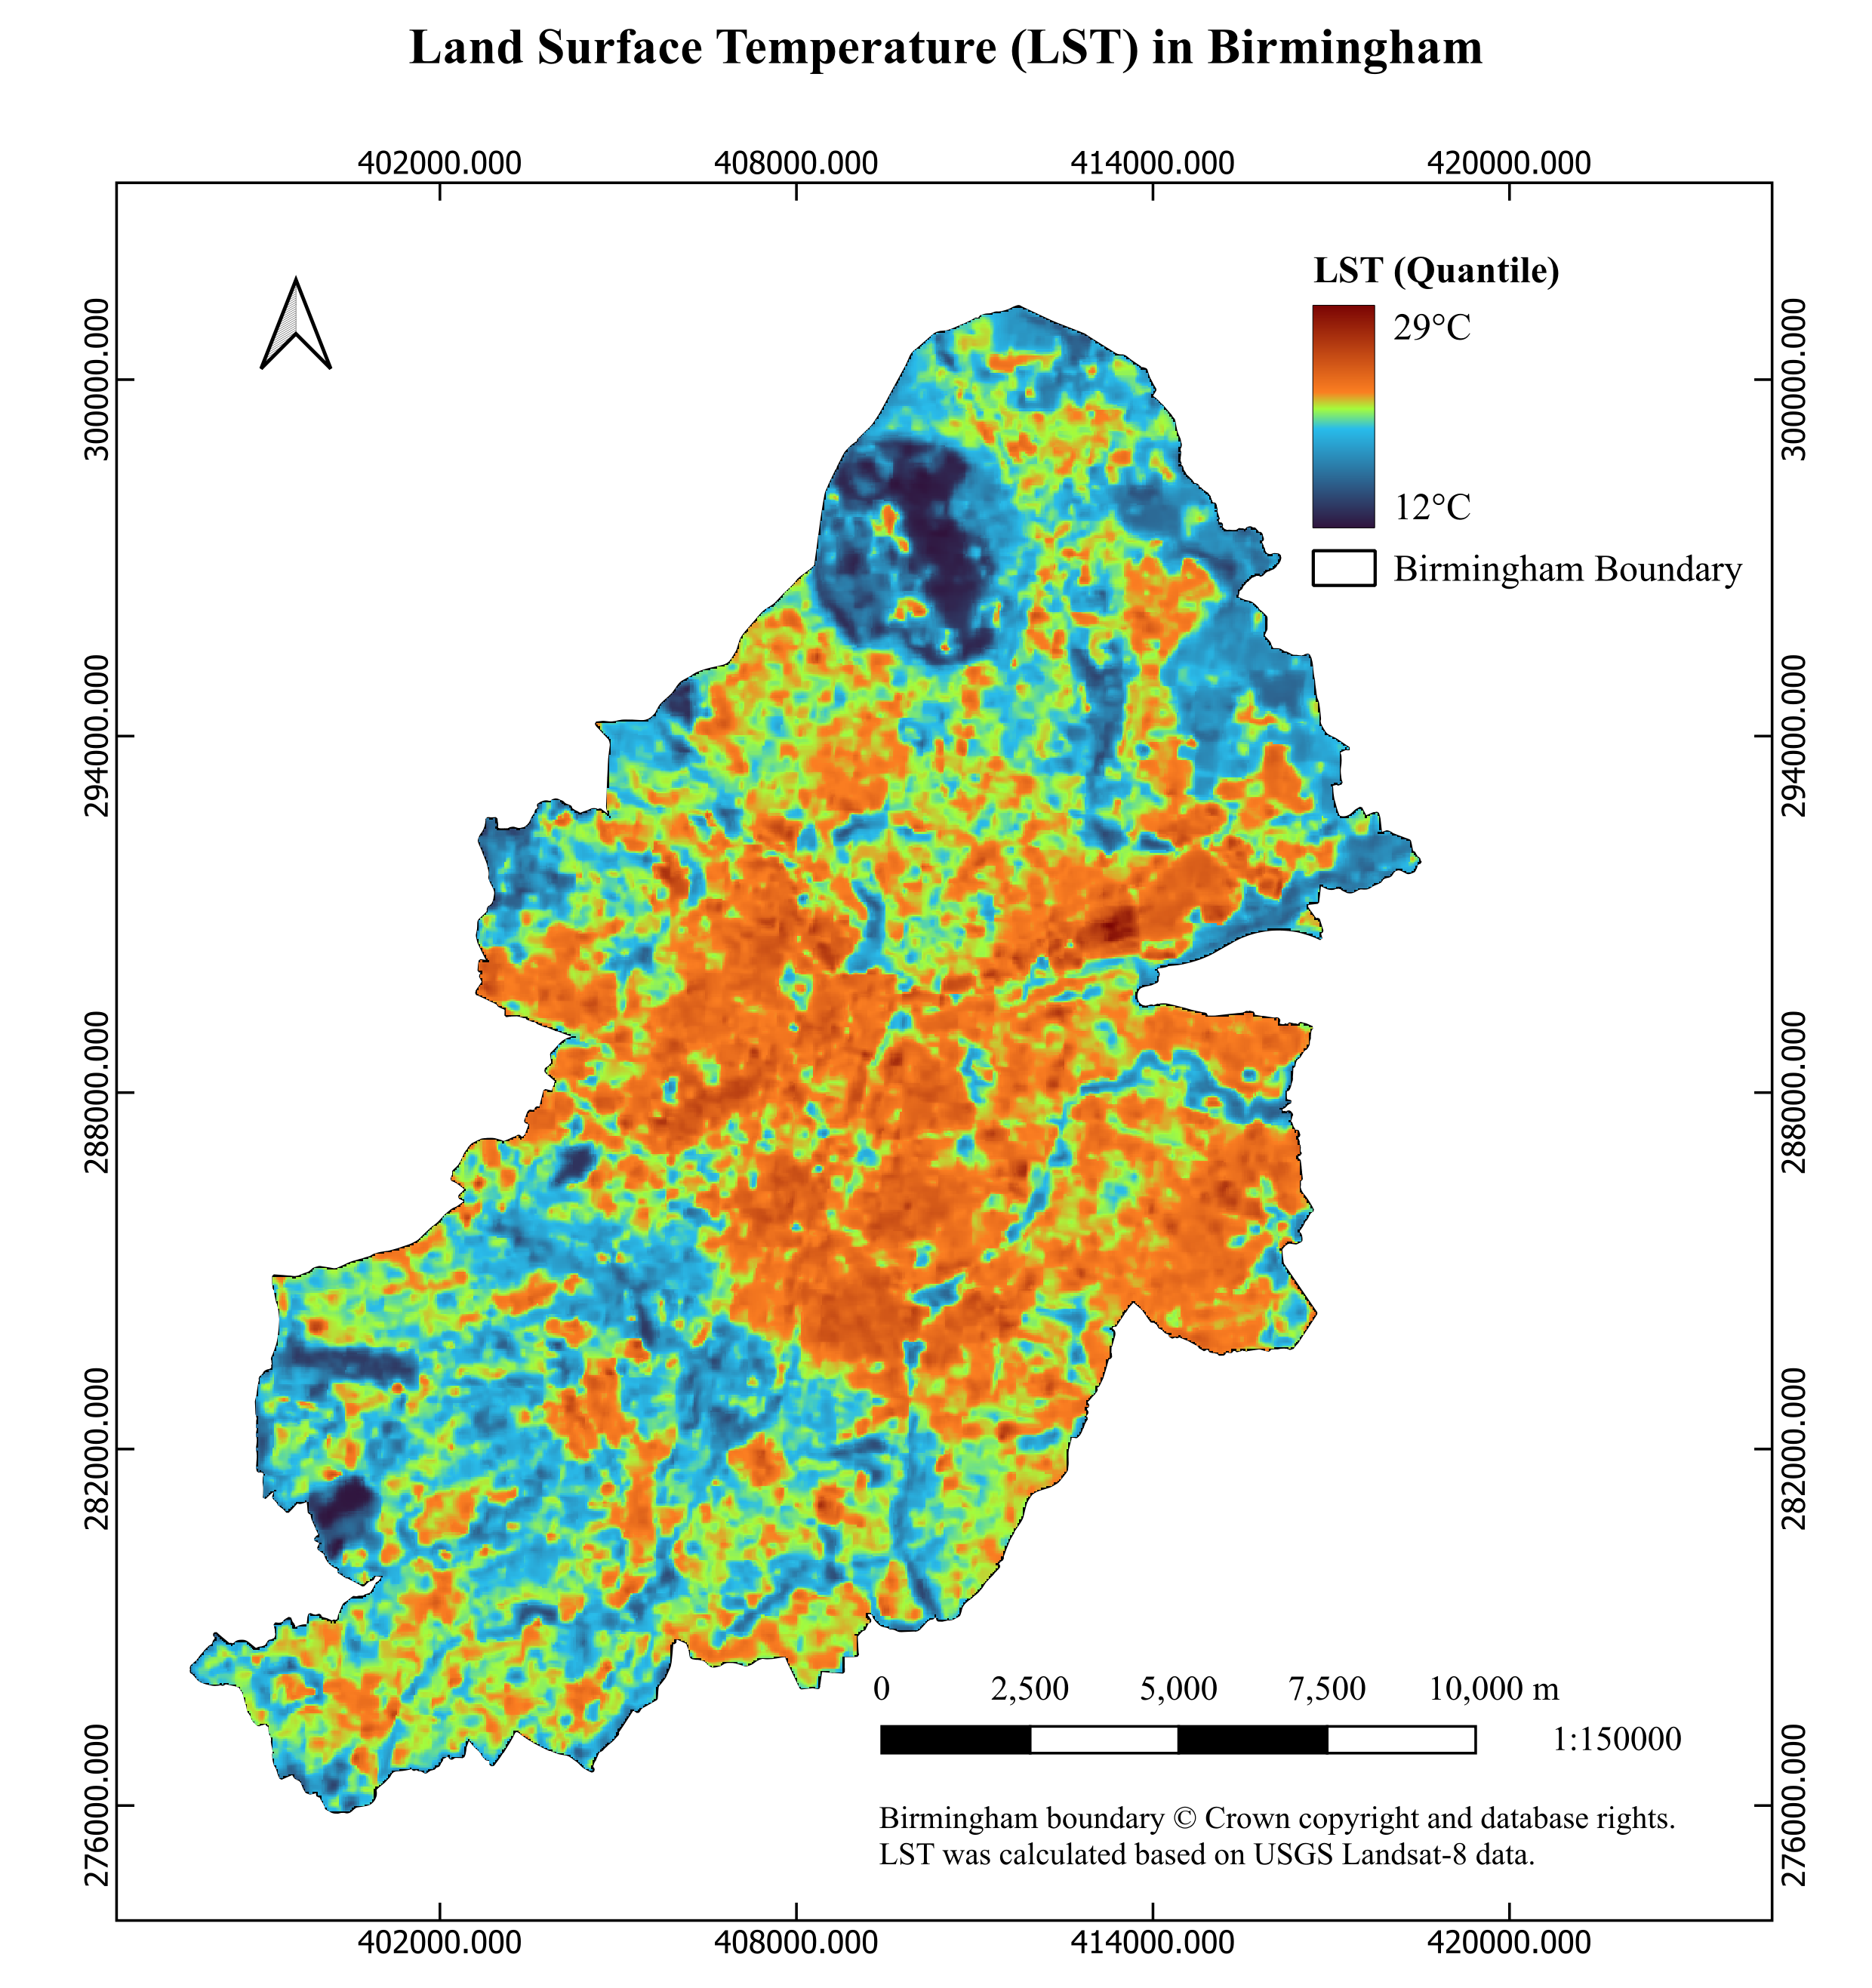

### 3. Performing Hotspot Analysis on LST

In [62]:
# Import libraries
import geopandas as gpd
from pysal.explore import esda
from pysal.lib import weights
import matplotlib.pyplot as plt
%matplotlib inline

In [63]:
# Read the shapefile data using geopandas
data = gpd.read_file('dataset/Birmingham_LST_result_by_ward.shp')

In [64]:
data.head()

,label,name,wd22cd,wd22nm,wd22nmw,Birmingham,Birmingh_1,Birmingh_2,Birmingh_3,Birmingh_4,geometry
0,E92000001E12000005E08000025E05011152,Longbridge & West Heath,E05011152,Longbridge & West Heath,None,17.406238,E92000001E12000005E08000025E05011152,Longbridge & West Heath,Longbridge & West Heath,None,"POLYGON ((403325.904 277254.906, 403322.505 27..."
1,E92000001E12000005E08000025E05011184,Weoley & Selly Oak,E05011184,Weoley & Selly Oak,None,19.932384,E92000001E12000005E08000025E05011184,Weoley & Selly Oak,Weoley & Selly Oak,None,"POLYGON ((402457.709 280548.321, 402415.244 28..."
2,E92000001E12000005E08000025E05011133,Druids Heath & Monyhull,E05011133,Druids Heath & Monyhull,None,21.120454,E92000001E12000005E08000025E05011133,Druids Heath & Monyhull,Druids Heath & Monyhull,None,"POLYGON ((407792.504 278525.089, 407779.118 27..."
3,E92000001E12000005E08000025E05011178,Sutton Trinity,E05011178,Sutton Trinity,None,21.369525,E92000001E12000005E08000025E05011178,Sutton Trinity,Sutton Trinity,None,"POLYGON ((408251.927 296797.664, 408260.042 29..."
4,E92000001E12000005E08000025E05011181,Sutton Wylde Green,E05011181,Sutton Wylde Green,None,19.437538,E92000001E12000005E08000025E05011181,Sutton Wylde Green,Sutton Wylde Green,None,"POLYGON ((412088.680 292934.626, 412088.077 29..."


In [65]:
# Rename the column
data.rename(columns={'Birmingham': 'lst_value'}, inplace=True)
data.head()

,label,name,wd22cd,wd22nm,wd22nmw,lst_value,Birmingh_1,Birmingh_2,Birmingh_3,Birmingh_4,geometry
0,E92000001E12000005E08000025E05011152,Longbridge & West Heath,E05011152,Longbridge & West Heath,None,17.406238,E92000001E12000005E08000025E05011152,Longbridge & West Heath,Longbridge & West Heath,None,"POLYGON ((403325.904 277254.906, 403322.505 27..."
1,E92000001E12000005E08000025E05011184,Weoley & Selly Oak,E05011184,Weoley & Selly Oak,None,19.932384,E92000001E12000005E08000025E05011184,Weoley & Selly Oak,Weoley & Selly Oak,None,"POLYGON ((402457.709 280548.321, 402415.244 28..."
2,E92000001E12000005E08000025E05011133,Druids Heath & Monyhull,E05011133,Druids Heath & Monyhull,None,21.120454,E92000001E12000005E08000025E05011133,Druids Heath & Monyhull,Druids Heath & Monyhull,None,"POLYGON ((407792.504 278525.089, 407779.118 27..."
3,E92000001E12000005E08000025E05011178,Sutton Trinity,E05011178,Sutton Trinity,None,21.369525,E92000001E12000005E08000025E05011178,Sutton Trinity,Sutton Trinity,None,"POLYGON ((408251.927 296797.664, 408260.042 29..."
4,E92000001E12000005E08000025E05011181,Sutton Wylde Green,E05011181,Sutton Wylde Green,None,19.437538,E92000001E12000005E08000025E05011181,Sutton Wylde Green,Sutton Wylde Green,None,"POLYGON ((412088.680 292934.626, 412088.077 29..."


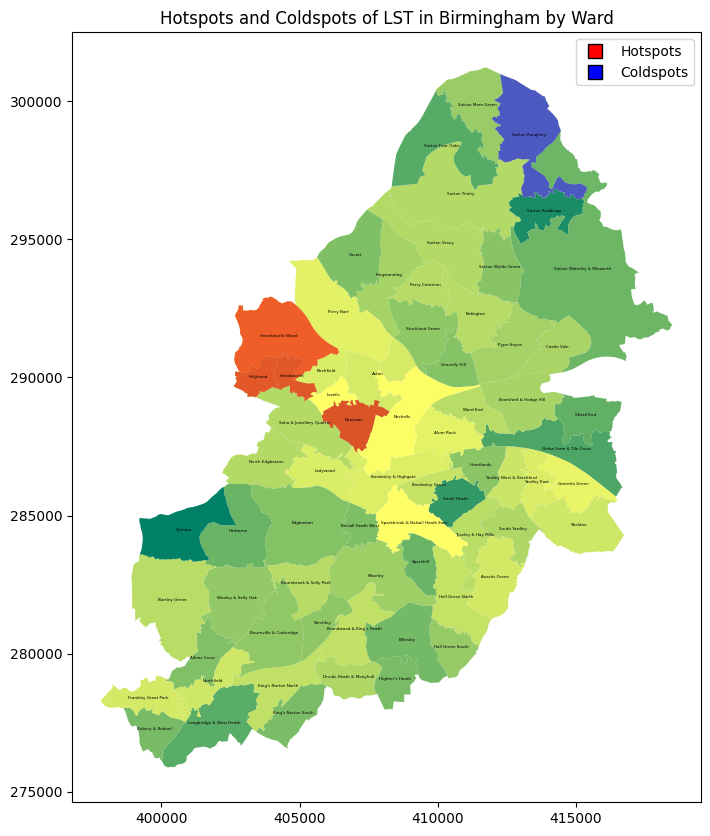

In [66]:
# Create a spatial weights matrix
w = weights.KNN.from_dataframe(data, k=5)

# Calculate Getis-Ord Gi* statistic
gi = esda.G_Local(data['lst_value'], w)

# Extract hotspots (Gi* z-scores > 1.96) and coldspots (Gi* z-scores < -1.96)
hotspots = data[gi.z_sim > 1.96]
coldspots = data[gi.z_sim < -1.96]

# Plot results for hotspots and coldspots
f, ax = plt.subplots(1, figsize=(10, 10))
data.plot(ax=ax, column='lst_value', cmap='summer')

# Plot hotspots (if they exist) in red
if not hotspots.empty:
    hotspots.plot(ax=ax, color='red', alpha=0.6, label='Hotspots')

# Plot coldspots (if they exist) in blue
if not coldspots.empty:
    coldspots.plot(ax=ax, color='blue', alpha=0.6, label='Coldspots')

# Create legend handles and labels for both hotspots and coldspots
handles, labels = [], []
if not hotspots.empty:
    handles.append(Line2D([0], [0], marker='s', color='none', markerfacecolor='red', markersize=10))
    labels.append('Hotspots')
else:
    # If there are no hotspots, add an empty handle and label to display both categories in the legend
    handles.append(Line2D([0], [0], color='none', markerfacecolor='none'))
    labels.append('Hotspots')
if not coldspots.empty:
    handles.append(Line2D([0], [0], marker='s', color='none', markerfacecolor='blue', markersize=10))
    labels.append('Coldspots')
else:
    # If there are no coldspots, add an empty handle and label to display both categories in the legend
    handles.append(Line2D([0], [0], color='none', markerfacecolor='none'))
    labels.append('Coldspots')

# Annotate wards with their names
for idx, row in data.iterrows():
    plt.annotate(text=row['wd22nm'], xy=(row.geometry.centroid.x, row.geometry.centroid.y), ha='center', fontsize=3)
    
plt.title('Hotspots and Coldspots of LST in Birmingham by Ward')
plt.legend(handles, labels)